In [119]:
import pickle
from PyFVCOM.read import FileReader
from PyFVCOM.plot import Plotter, Time, Depth
from cmocean import cm
import numpy as np
import matplotlib.pyplot as plt
from PyFVCOM.tide import make_water_column
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import deepcopy

In [120]:
with open('duanmian.pkl','rb') as f:
    ds = pickle.load(f)

In [3]:
datapath = '/public/home/gaoguandong/xrsh/work/pic/data/'
picpath = '/public/home/gaoguandong/xrsh/work/pic/pics/duanmian/sectionBC/'

pkl_file = open('zhouwei_fvcom.pkl', 'rb')
fvcom = pickle.load(pkl_file)

In [ ]:
# fill_seabed makes the part of the plot below the seabed grey.
z = make_water_column(ds.variables['zeta'][:]._data.T, ds.variables['h'][:]._data, fvcom.grid.siglay[:,0:8])
x = np.tile(ds.variables['lat'][:],(20,1))

In [40]:
def chuixiang(x,y,a,b):
    d = np.sqrt(a**2+b**2)
    
    a = a/d
    b = b/d
    print(a,b,d)
    #a = 0.9416
    #b = 0.3366
    #print(a,b)
    xx = x*a + y*b
    yy = -x*b + a*y
    return xx,yy

In [126]:
x = ds.variables['x']._data
y = ds.variables['y']._data

u = deepcopy(ds.variables['u']._data)
v = deepcopy(ds.variables['v']._data)

u[:5,],v[:5,] = chuixiang(u[:5,],v[:5,],x[0]-x[1],y[0]-y[1])
u[5:,],v[5:,] = chuixiang(u[5:,],v[5:,],x[-2]-x[-1],y[-2]-y[-1])

-0.4800684205556744 0.8772310480057007 179.80682832351116
0.12290619764153884 0.99241829214364 200.16932630500798


In [127]:
ds['cxu'] = (('loc','time','depth'),u)
ds['cxv'] = (('loc','time','depth'),v)
ds['z'] = (('depth','time','loc'),z)

In [123]:
#ds = ds.sortby('lon')
with open('duanmian.pkl','wb') as f:
    pickle.dump(ds,f)

In [124]:

def draw_par(plot):
    plot.axes.set_xlabel('Latitude')
    plot.axes.set_xticklabels([str(np.around(x,3)) + u'°S' for x in plot.axes.get_xticks()])
    plot.axes.set_ylabel('Depth (m)')
    plot.axes.set_xlim(-32.27,-32.244)
    plot.axes.set_ylim(top=3)

    #plt.text(0.82,0.1, r'$scale:$', color='r',transform=plot.axes.transAxes, fontweight=100, fontsize=18)
    plt.text(0.856,0.07, r'$0.1m/s$', color='r',transform=plot.axes.transAxes, fontweight=100, fontsize=18)
    #plt.quiver(115.73, -19.5, 0.1, 0, color='r', width=0.0017,scale=2)

def contour_adjust(plot):
    plot.axes.set_xlim(-32.27,-32.244)
    plot.axes.set_ylim(bottom=-1)
    plot.axes.invert_yaxis()
    plot.axes.fill_between(ds.variables['lat'][:], np.max(depth, axis=0), plot.axes.get_ylim()[0], color='0.6',zorder = 100)
    plot.axes.set_xlabel('Latitude')
    plot.axes.set_xticklabels([str(np.around(x,3)) + u'°S' for x in plot.axes.get_xticks()])
    plot.axes.set_ylabel('Depth (m)')

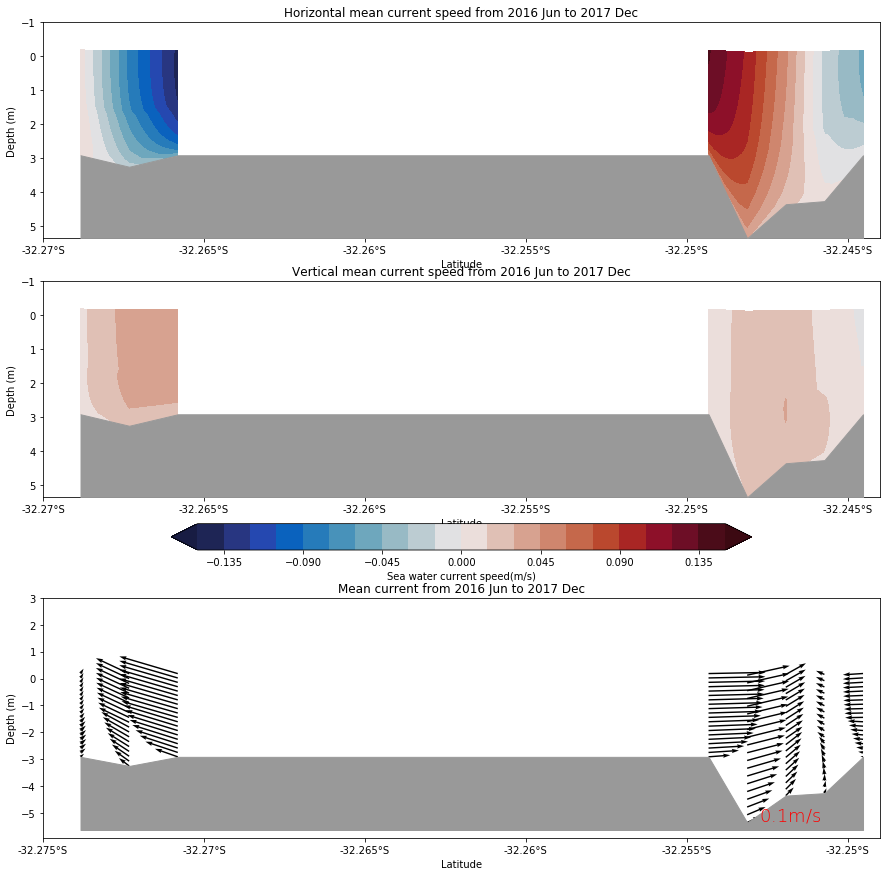

In [128]:
## all average
#z = make_water_column(ds.variables['zeta'][:]._data.T, ds.variables['h'][:]._data, fvcom2.grid.siglay[:,0:31])
x = np.tile(ds.variables['lat'][:],(20,1))
zu = np.mean(ds.variables['cxu'][:].T,1)._data
zv = np.mean(ds.variables['cxv'][:].T,1)._data
levels = MaxNLocator(nbins=25).tick_values(-np.array([np.abs(zu),np.abs(zv)]).max(), np.array([np.abs(zu),np.abs(zv)]).max())
fig, axs = plt.subplots(3,1,figsize=(15, 15))
ax = axs[0]
plot = Depth(fvcom,figure = fig, axes = ax, 
             cb_label='Current speed ({})'.format(fvcom.atts.u.units),
             cmap=cm.balance)


depth = (-np.mean(z,1))._data
tp = plot.axes.contourf(x[:,:5], depth[:,:5],zu[:,:5] ,cmap=cm.balance,levels = levels)
tp = plot.axes.contourf(x[:,-3:], depth[:,-3:],zu[:,-3:] ,cmap=cm.balance,levels = levels)
contour_adjust(plot)
plot.axes.set_title('Horizontal mean current speed from 2016 Jun to 2017 Dec')
zvar = np.mean(ds.variables['v'][:].T,1)._data


plot.axes = axs[1]
depth = (-np.mean(z,1))._data
tp = plot.axes.contourf(x[:,:5], depth[:,:5],zv[:,:5] ,cmap=cm.balance,levels = levels)
tp = plot.axes.contourf(x[:,-3:], depth[:,-3:],zv[:,-3:] ,cmap=cm.balance,levels = levels,extend = 'both')
contour_adjust(plot)
plot.axes.set_title('Vertical mean current speed from 2016 Jun to 2017 Dec')

cb = fig.colorbar(tp, ax=axs[0:2],orientation= "horizontal", pad=0.05, fraction=.05,extendrect = False,shrink = 0.7)
cb.set_label("Sea water current speed(m/s)")

## all average
#z = make_water_column(ds.variables['zeta'][:]._data.T, ds.variables['h'][:]._data, fvcom2.grid.siglay[:,0:31])

plot.axes = axs[2]
plot.plot_quiver(x, depth,
                zu,
                zv,
                fill_seabed=True,
                width=0.0017,scale = 2)
draw_par(plot)
plot.axes.set_title('Mean current from 2016 Jun to 2017 Dec')
#plt.savefig(picpath+'all_uv_vec.png')

plt.savefig(picpath+'all_uv.png')
plt.show()

# Year Mean

In [129]:
zu = ds.resample(time = '1y').mean()['cxu']
zv = ds.resample(time = '1y').mean()['cxv']
zz = ds.resample(time = '1y').mean()['z']

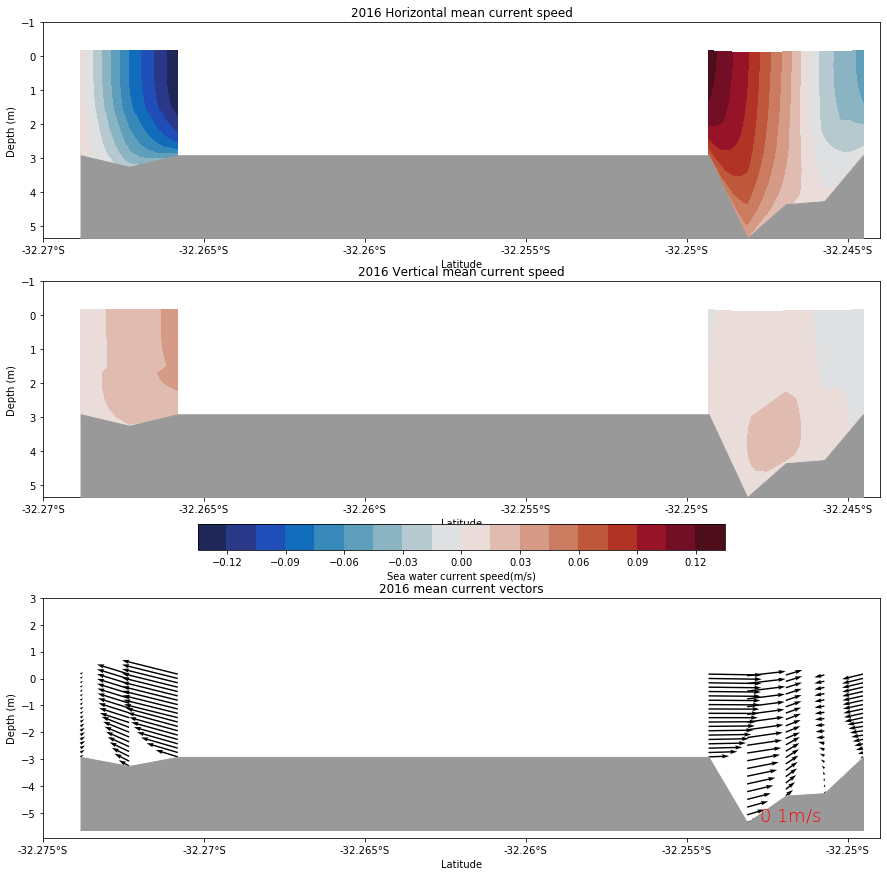

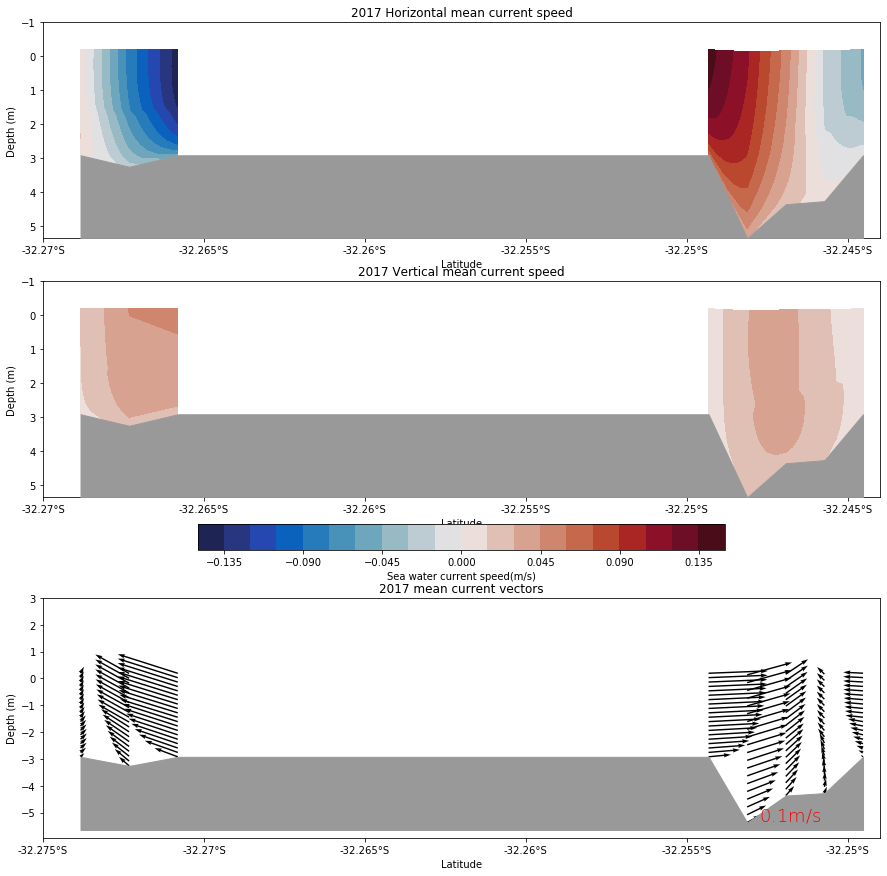

In [130]:
image_list = []
for picn, pictime in enumerate(zz.time):
    timestr = str(pictime._variable._data)[:4]
    zuu = zu._variable._data[picn,:,:].T
    zvv = zv._variable._data[picn,:,:].T
    levels = MaxNLocator(nbins=25).tick_values(-np.array([np.abs(zuu),np.abs(zvv)]).max(), np.array([np.abs(zuu),np.abs(zvv)]).max())
    fig, axs = plt.subplots(3,1,figsize=(15, 15))
    ax = axs[0]
    plot = Depth(fvcom,figure = fig, axes = ax, 
                 cb_label='Current speed ({})'.format(fvcom.atts.u.units),
                 cmap=cm.balance)
    depth = -zz[picn,:,:]
    
    tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zuu[:,:5] ,cmap=cm.balance,levels = levels)
    tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zuu[:,5:] ,cmap=cm.balance,levels = levels)
    contour_adjust(plot)
    plot.axes.set_title(timestr+ ' Horizontal mean current speed')
    
    plot.axes = axs[1]
    #tp = plot.axes.contourf(x, depth , zvv ,cmap=cm.balance,levels = levels,extend = 'both')
    tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zvv[:,:5] ,cmap=cm.balance,levels = levels)
    tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zvv[:,5:] ,cmap=cm.balance,levels = levels)
    plot.axes.set_title(timestr+ ' Vertical mean current speed')
    contour_adjust(plot)
    
    # Add a nice colour bar.
    cb = fig.colorbar(tp, ax=axs[0:2],orientation= "horizontal", pad=0.05, fraction=.05,extendrect = False,shrink = 0.7)
    cb.set_label("Sea water current speed(m/s)")
    
    
    plot.axes = axs[2]
    plot.plot_quiver(x, depth,
                    zuu,
                    zvv,
                    fill_seabed=True,
                    width=0.0017,scale = 2)
    draw_par(plot)
    plot.axes.set_title(timestr+ ' mean current vectors')
    plt.savefig(picpath+timestr+'_uv.png')
    plt.show()

# Month Mean

In [131]:
zu = ds.resample(time = '1m').mean()['u']
zv = ds.resample(time = '1m').mean()['v']
zz = ds.resample(time = '1m').mean()['z']

In [132]:
str(pictime._variable._data)[:7]

'2017-12'

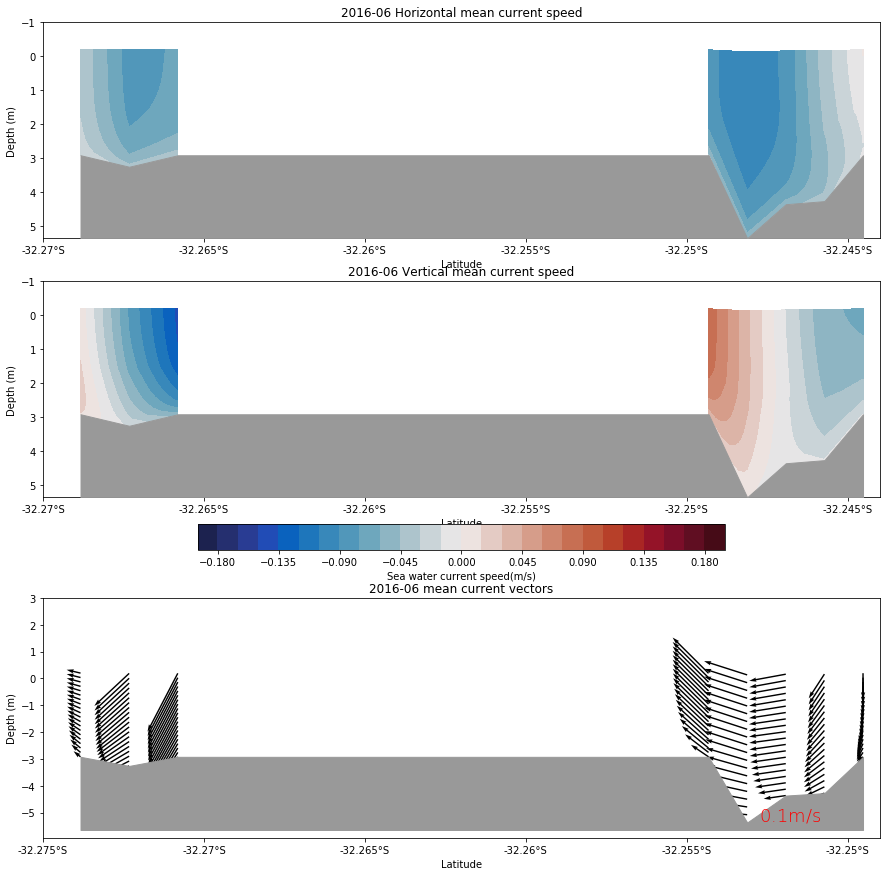

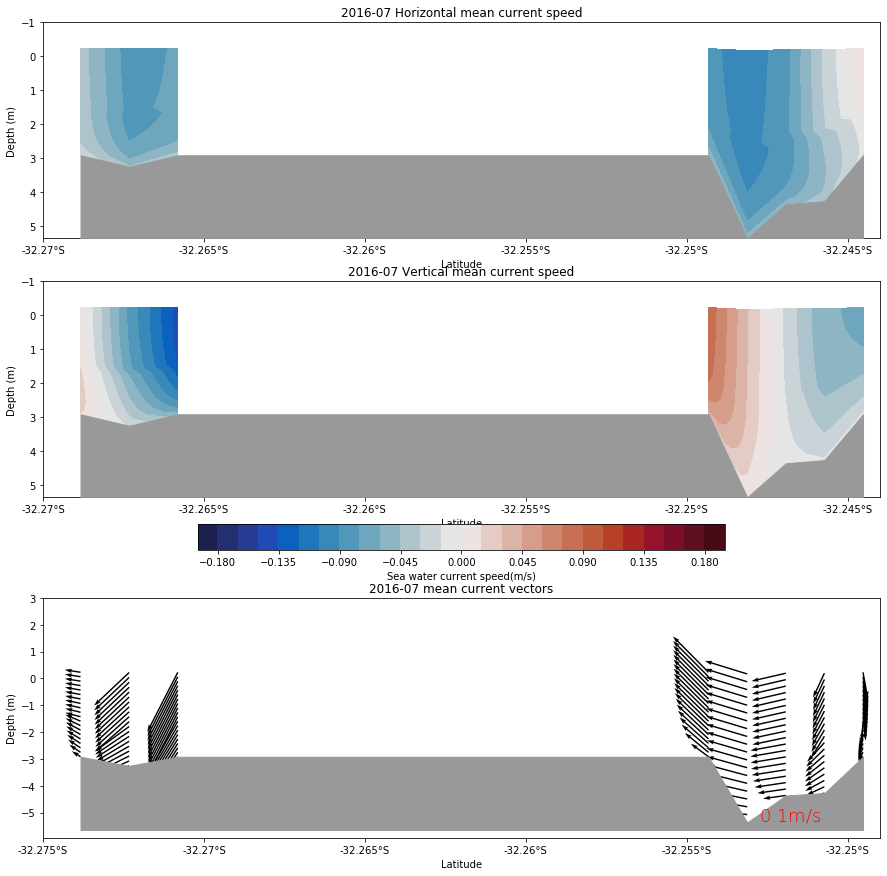

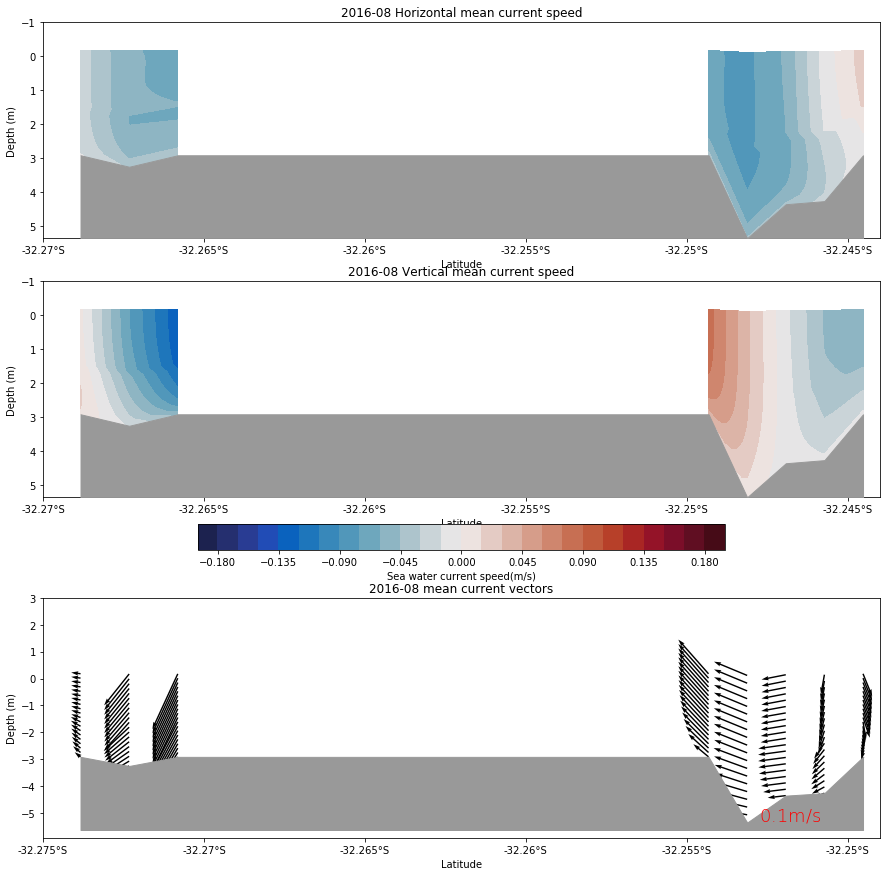

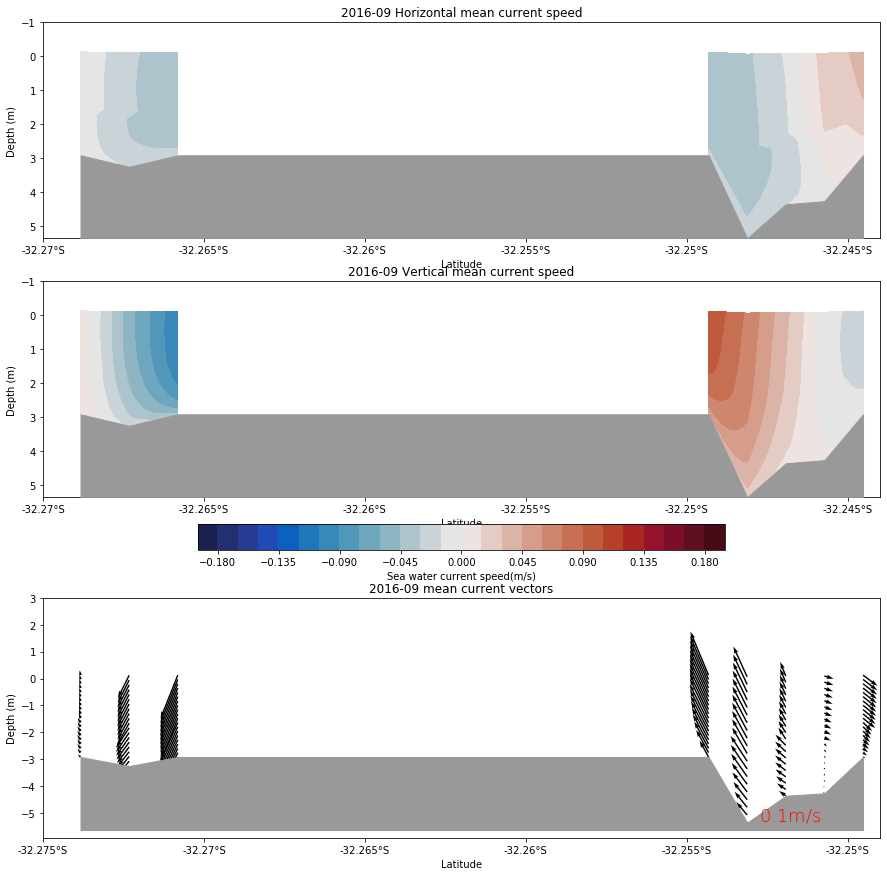

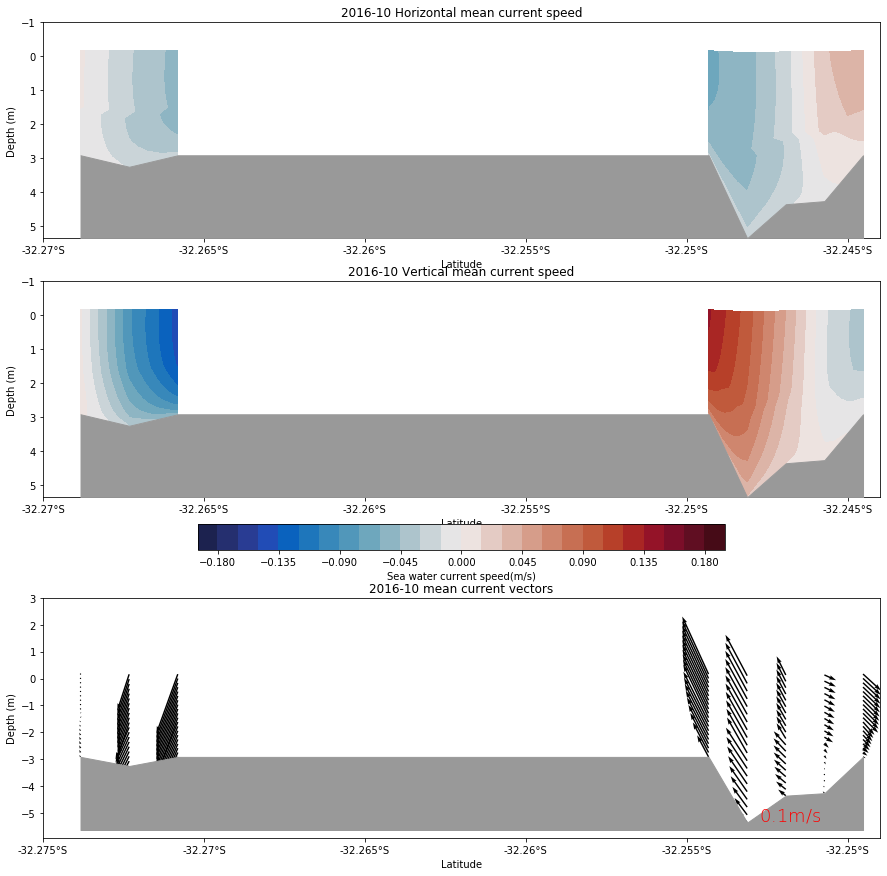

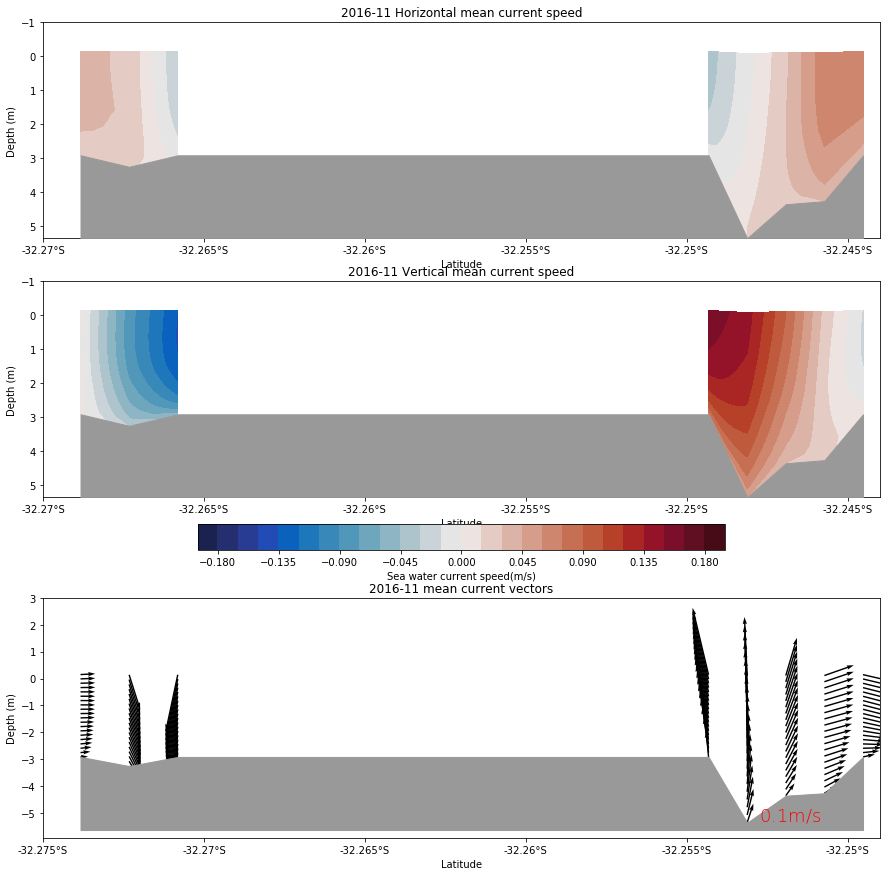

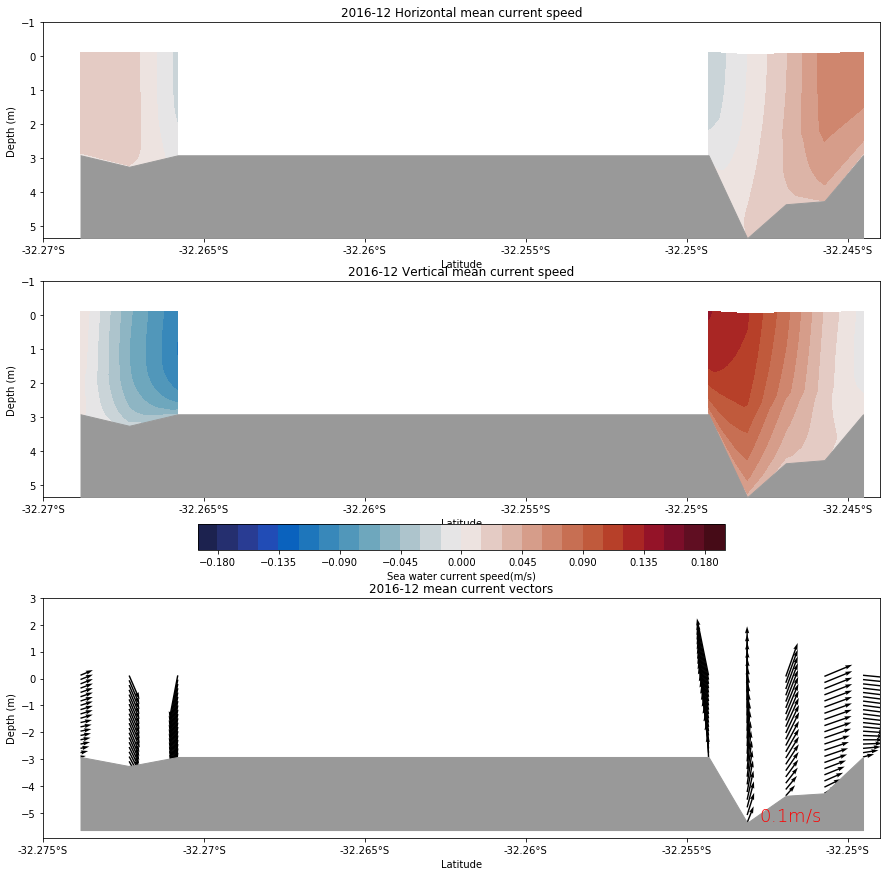

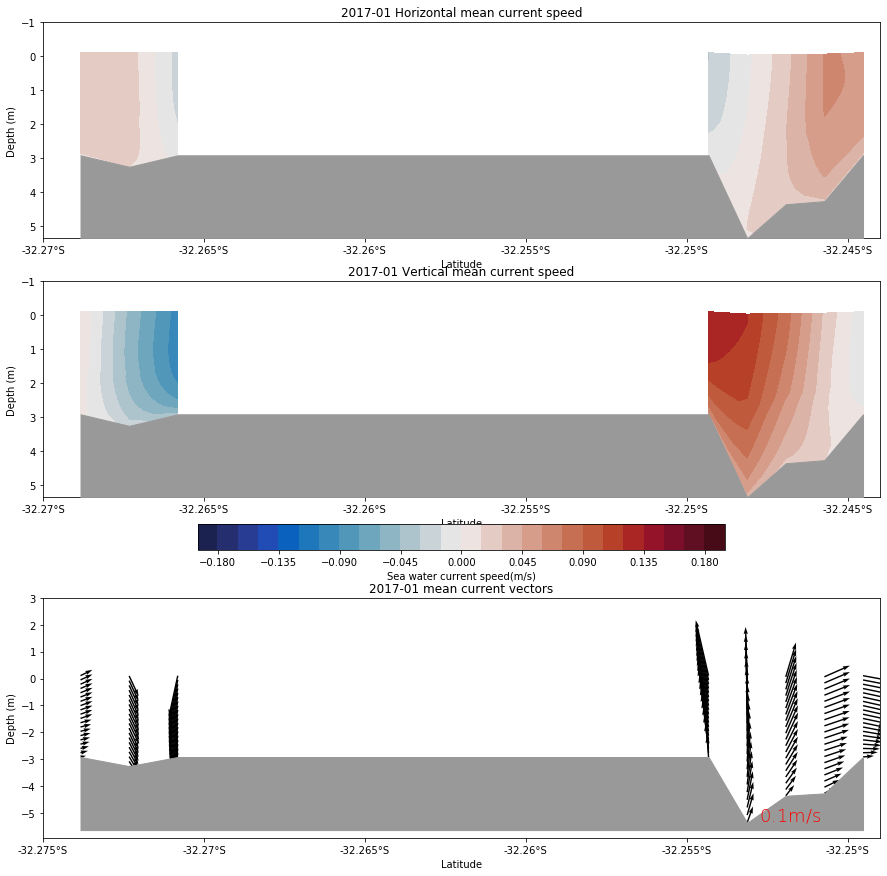

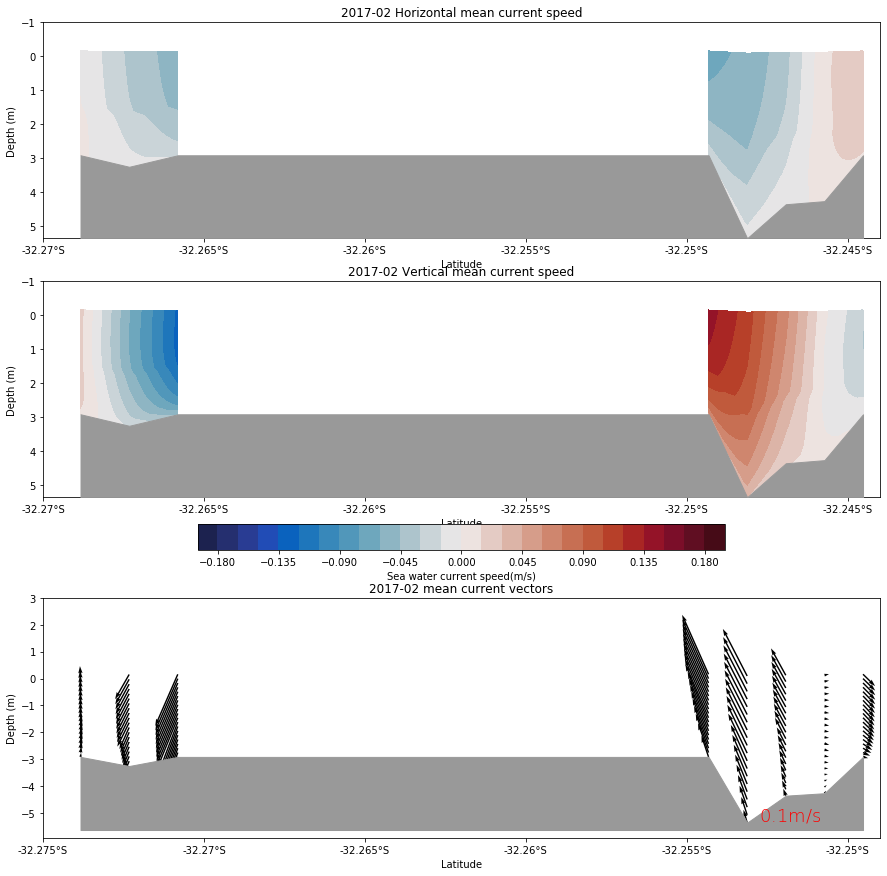

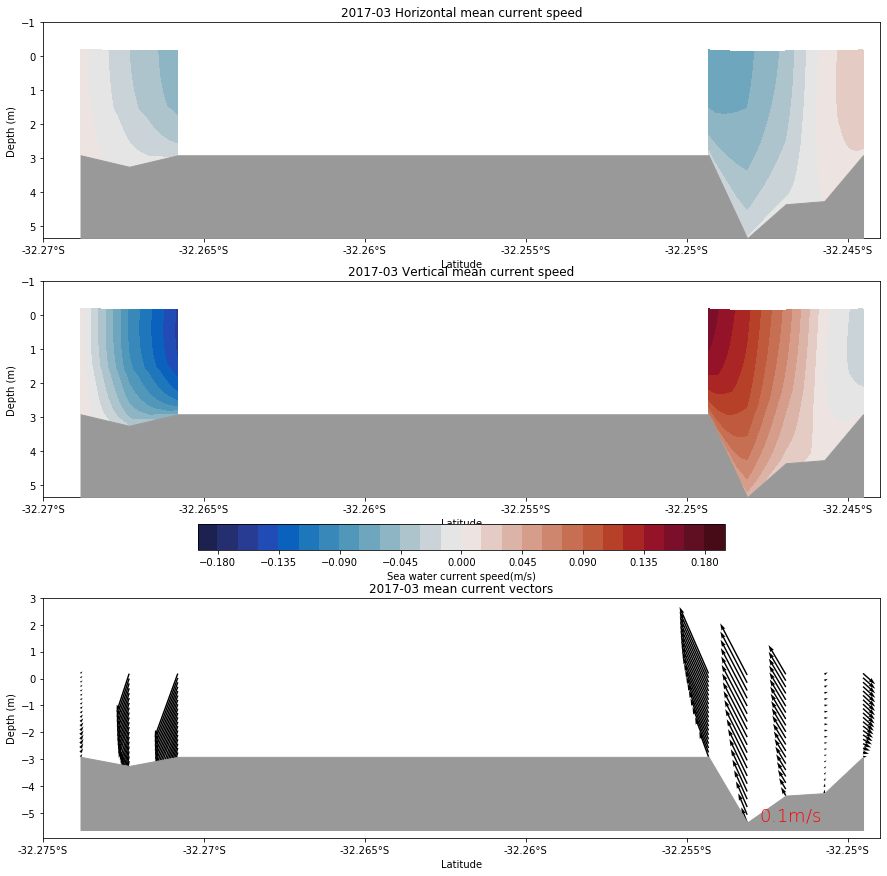

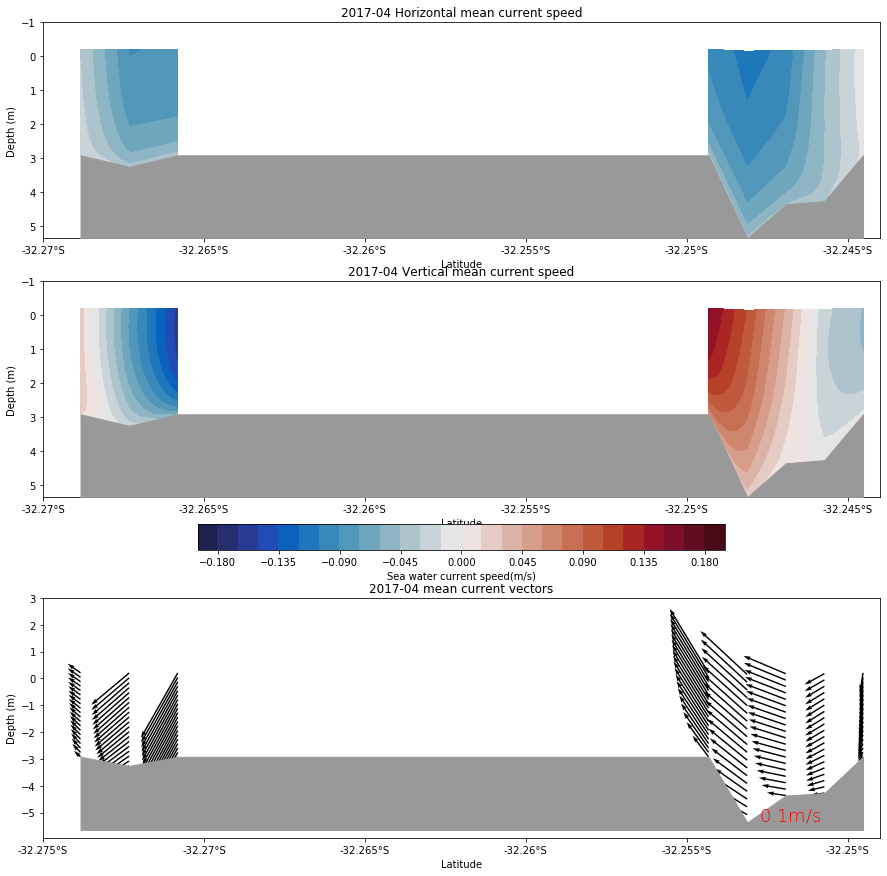

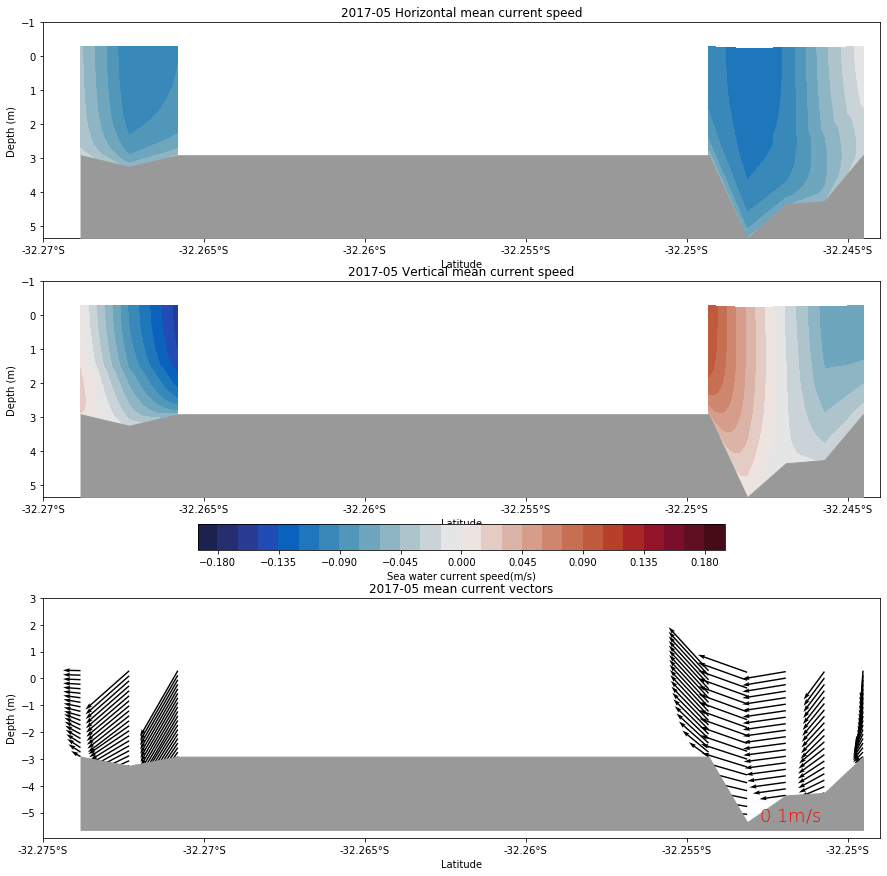

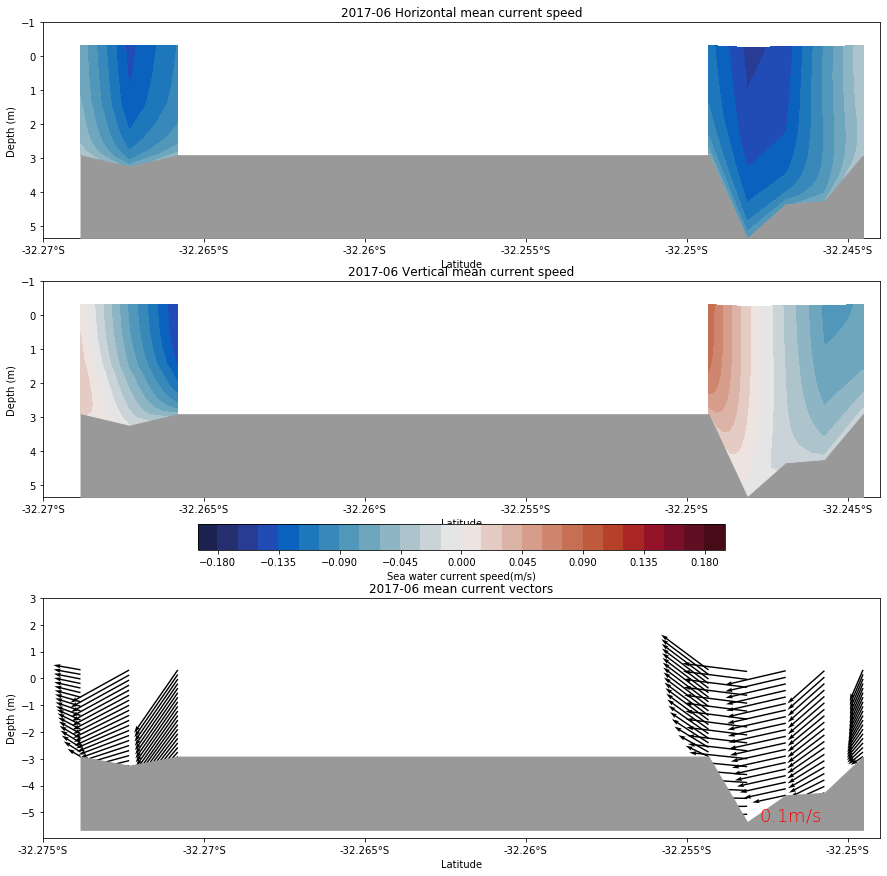

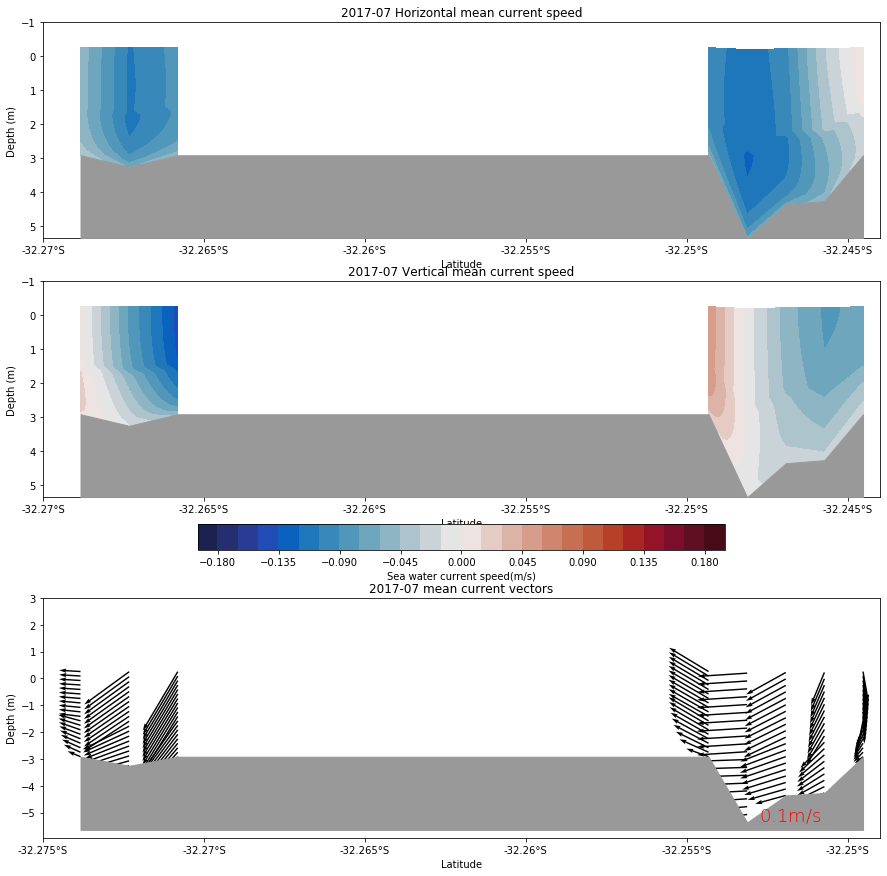

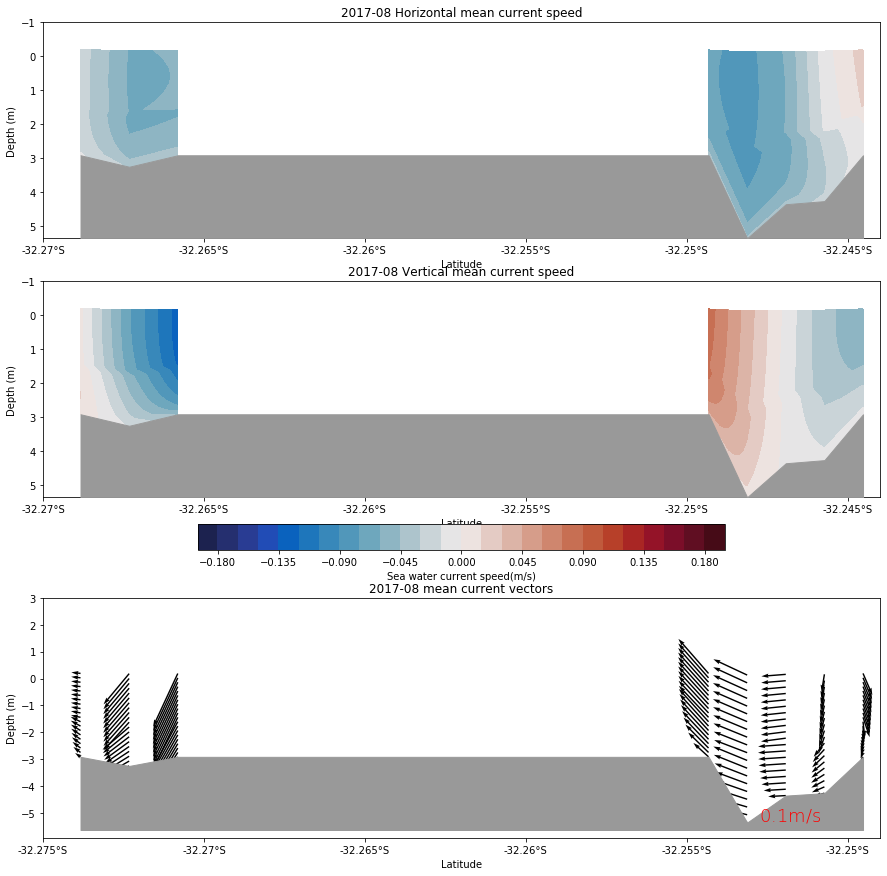

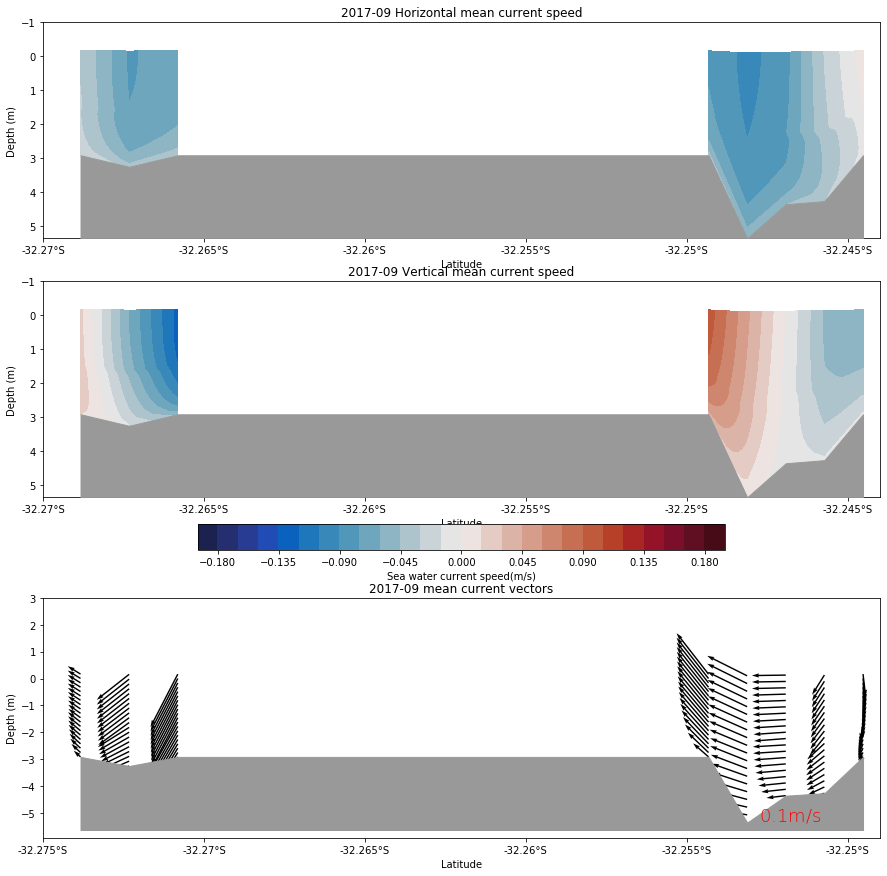

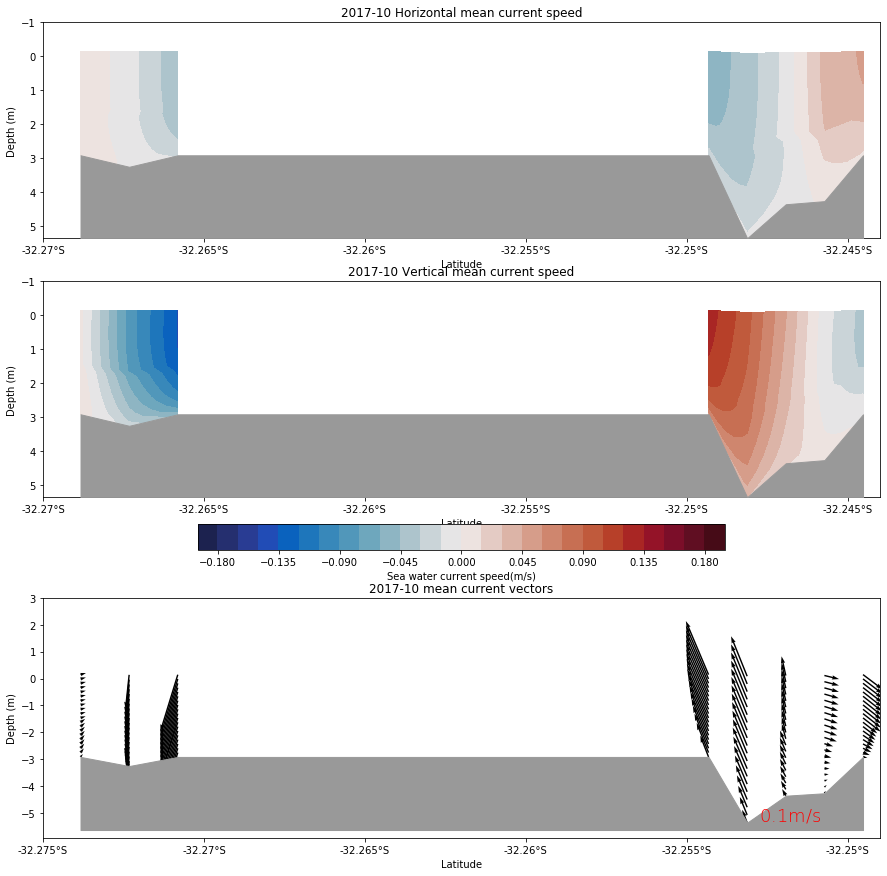

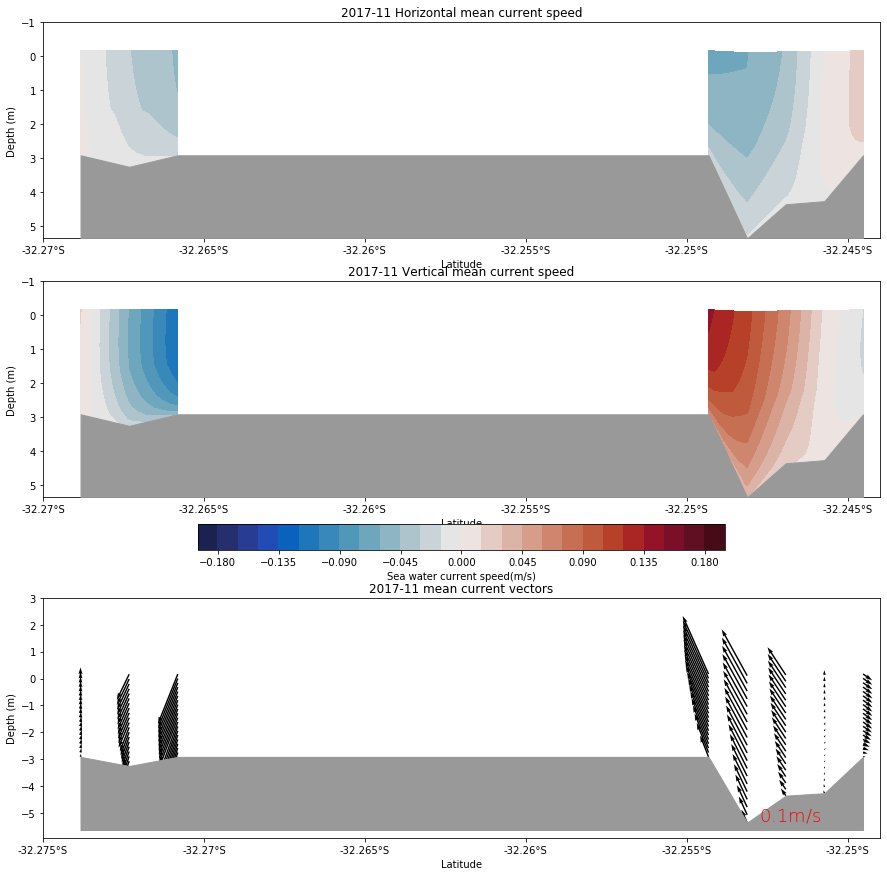

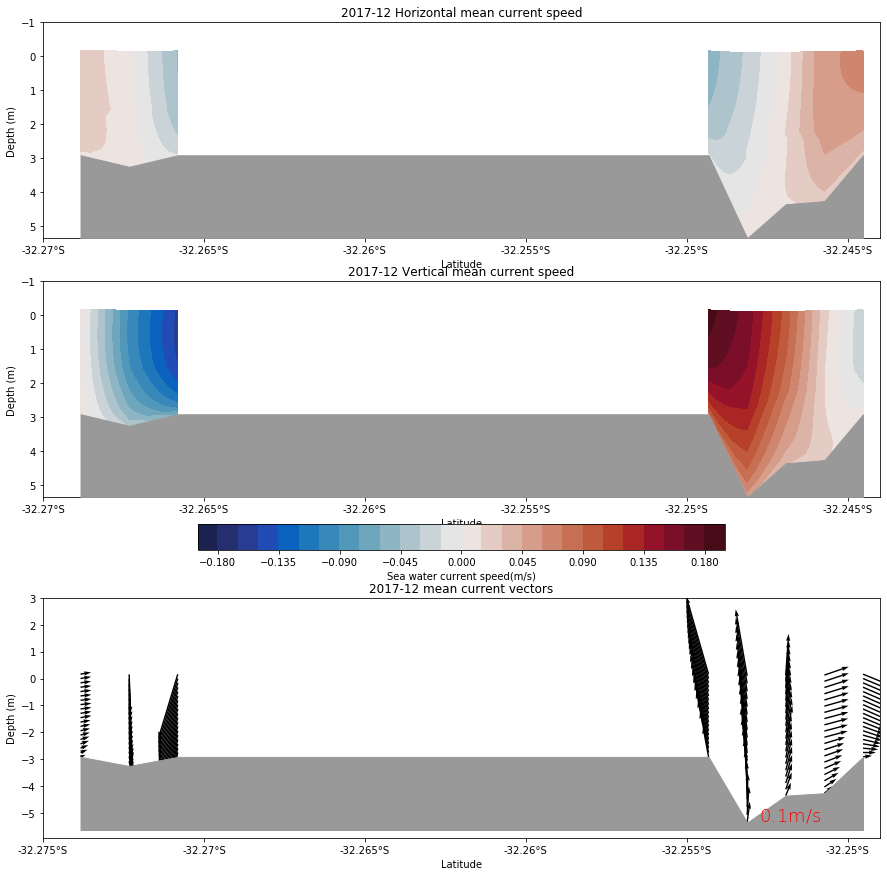

In [133]:
image_list = []
levels = MaxNLocator(nbins=25).tick_values(-np.array([np.abs(zu),np.abs(zv)]).max(), np.array([np.abs(zu),np.abs(zv)]).max())
for picn, pictime in enumerate(zz.time):
    timestr = str(pictime._variable._data)[:7]
    zuu = zu._variable._data[picn,:,:].T
    zvv = zv._variable._data[picn,:,:].T
    
    fig, axs = plt.subplots(3,1,figsize=(15, 15))
    ax = axs[0]
    plot = Depth(fvcom,figure = fig, axes = ax, 
                 cb_label='Current speed ({})'.format(fvcom.atts.u.units),
                 cmap=cm.balance)
    depth = -zz[picn,:,:]
    
    tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zuu[:,:5] ,cmap=cm.balance,levels = levels)
    tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zuu[:,5:] ,cmap=cm.balance,levels = levels)
    contour_adjust(plot)
    plot.axes.set_title(timestr+ ' Horizontal mean current speed')
    
    plot.axes = axs[1]
    tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zvv[:,:5] ,cmap=cm.balance,levels = levels)
    tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zvv[:,5:] ,cmap=cm.balance,levels = levels)
    plot.axes.set_title(timestr+ ' Vertical mean current speed')
    contour_adjust(plot)
    
    # Add a nice colour bar.
    cb = fig.colorbar(tp, ax=axs[0:2],orientation= "horizontal", pad=0.05, fraction=.05,extendrect = False,shrink = 0.7)
    cb.set_label("Sea water current speed(m/s)")
    
    
    plot.axes = axs[2]
    plot.plot_quiver(x, depth,
                    zuu,
                    zvv,
                    fill_seabed=True,
                    width=0.0017,scale = 2)
    draw_par(plot)
    plot.axes.set_title(timestr+ ' mean current vectors')
    plt.savefig(picpath+'month/'+timestr+'_uv.png')
    plt.show()

# Summer Week

In [134]:
zu = ds.resample(time = '1w').mean()['u']
zv = ds.resample(time = '1w').mean()['v']
zz = ds.resample(time = '1w').mean()['z']

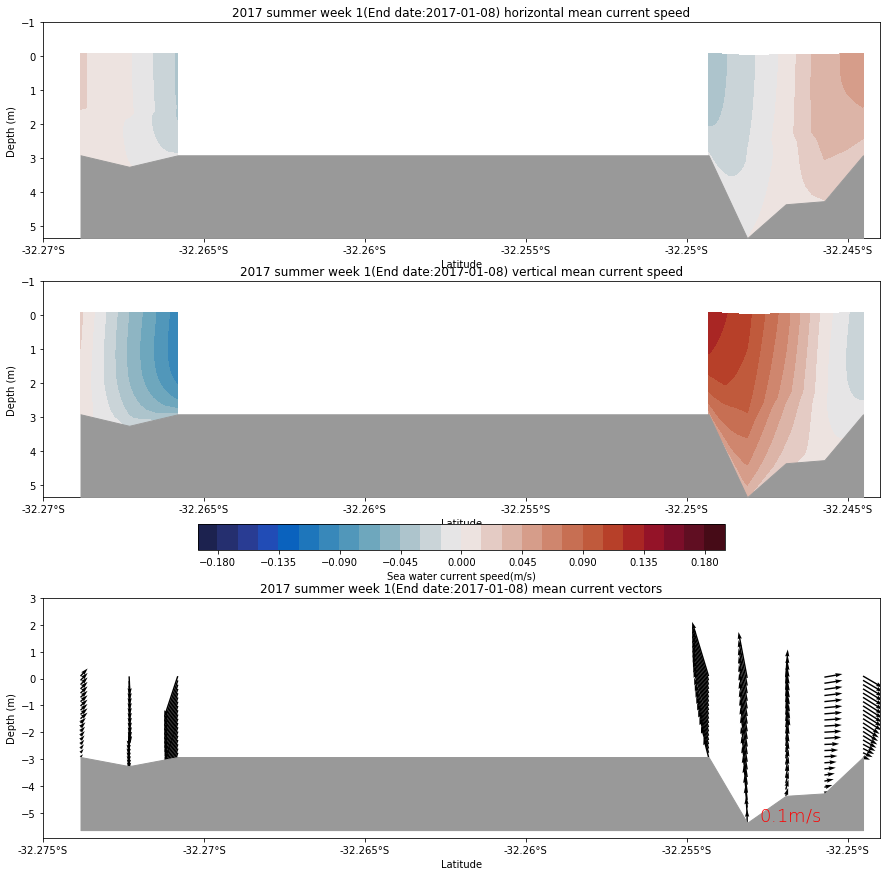

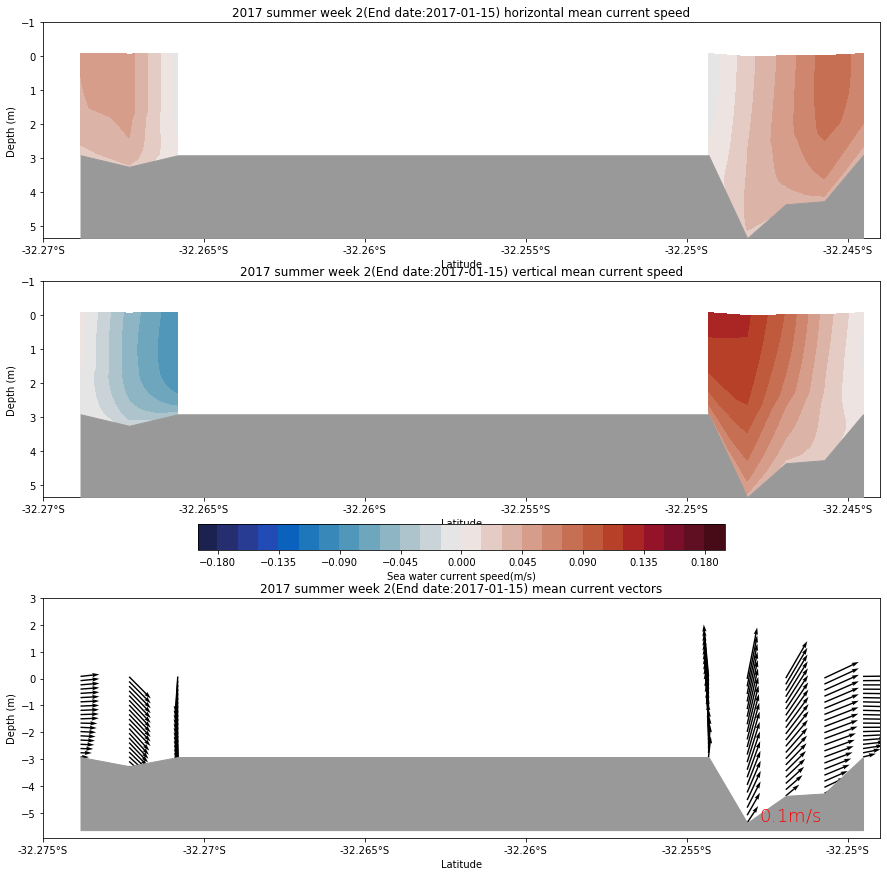

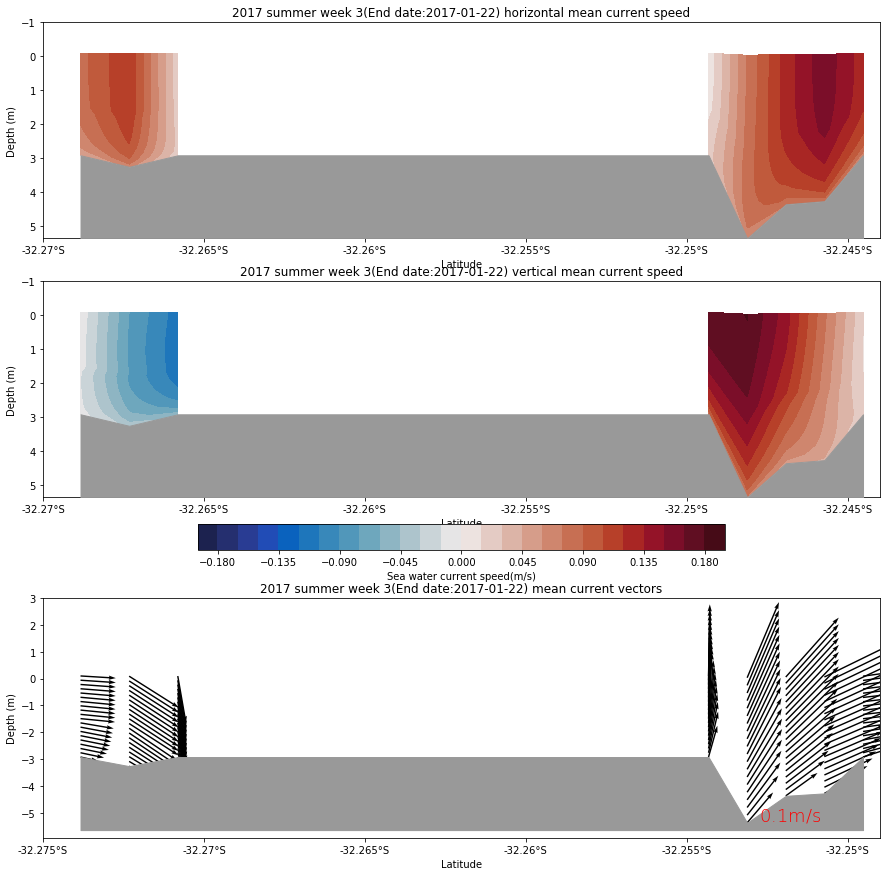

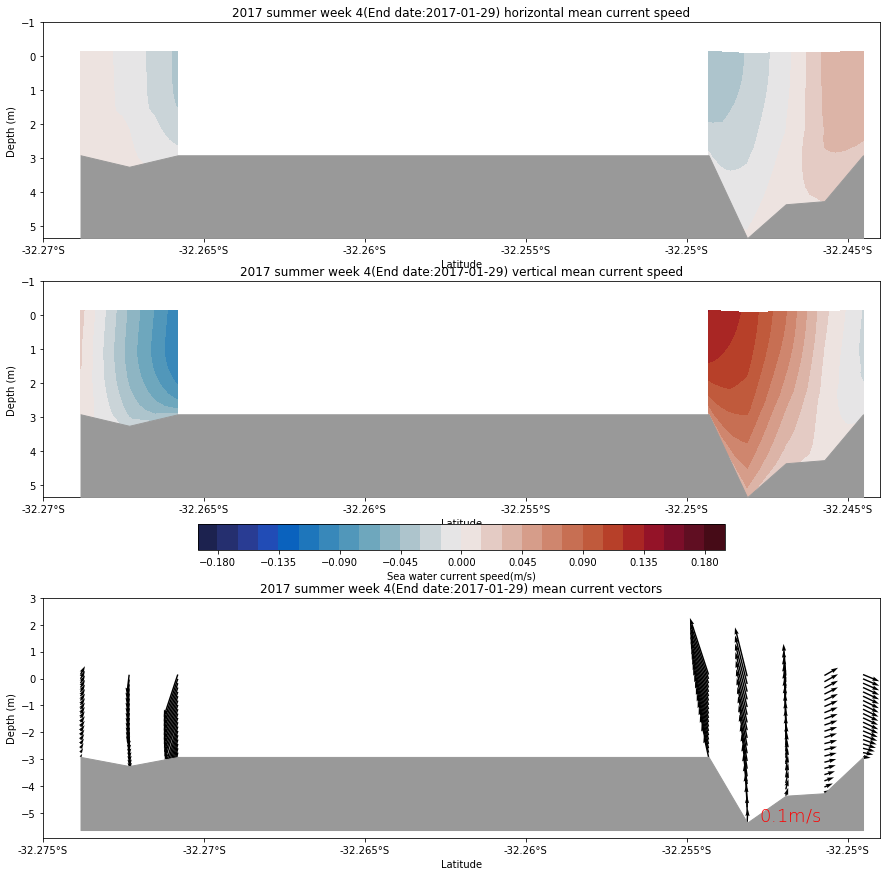

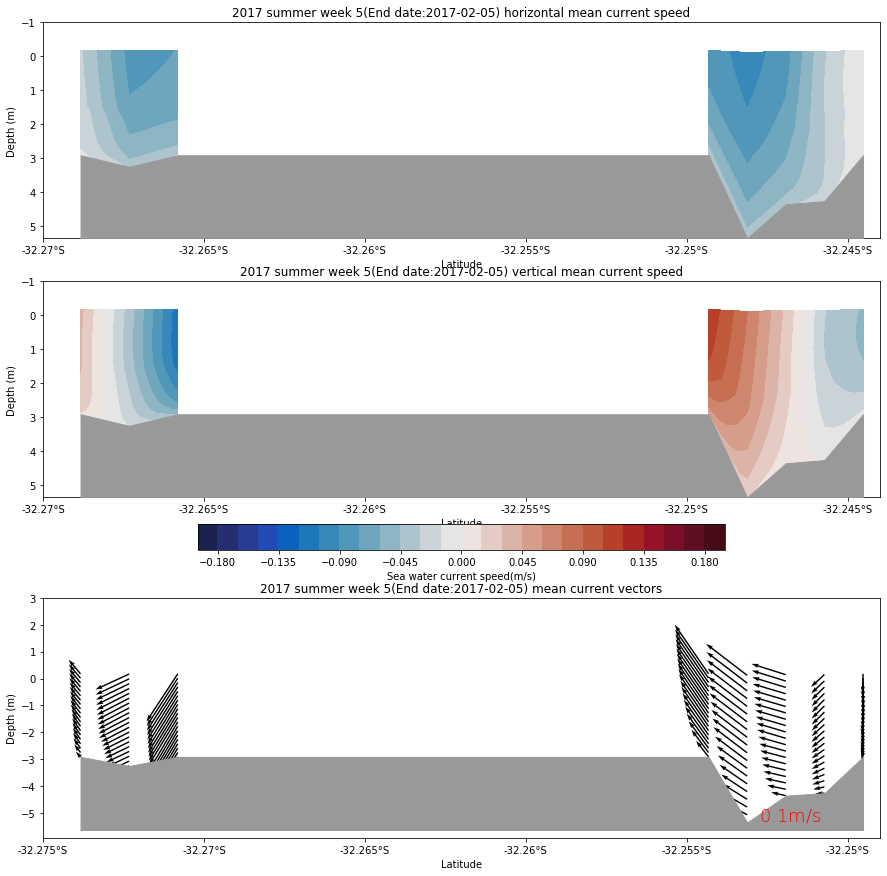

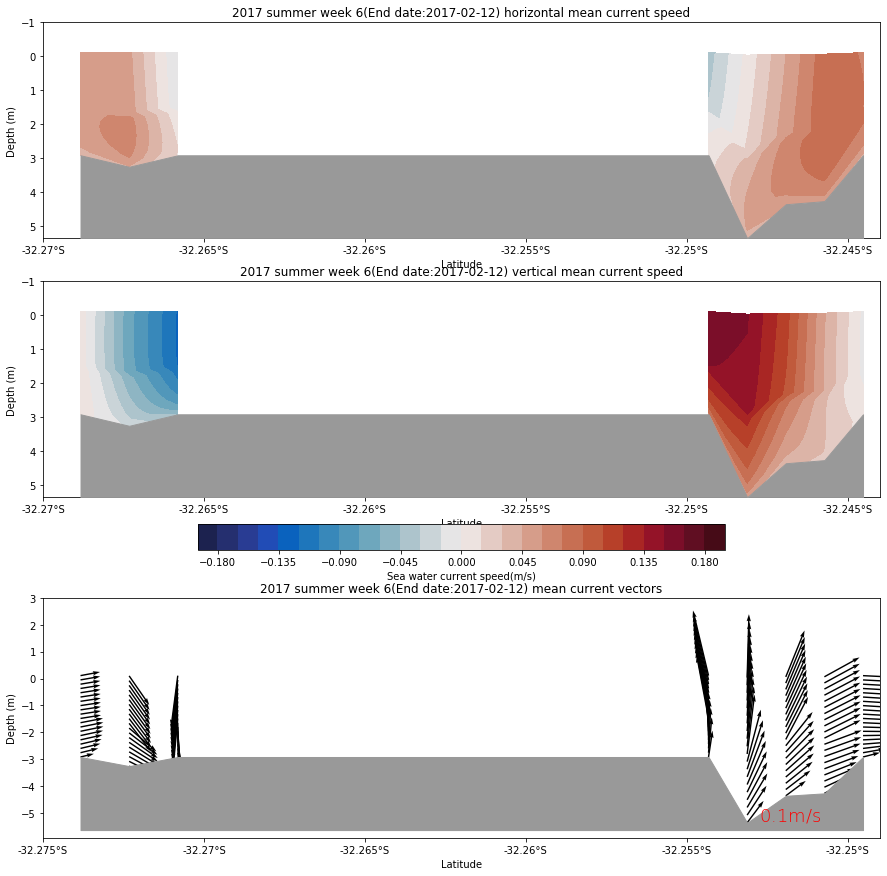

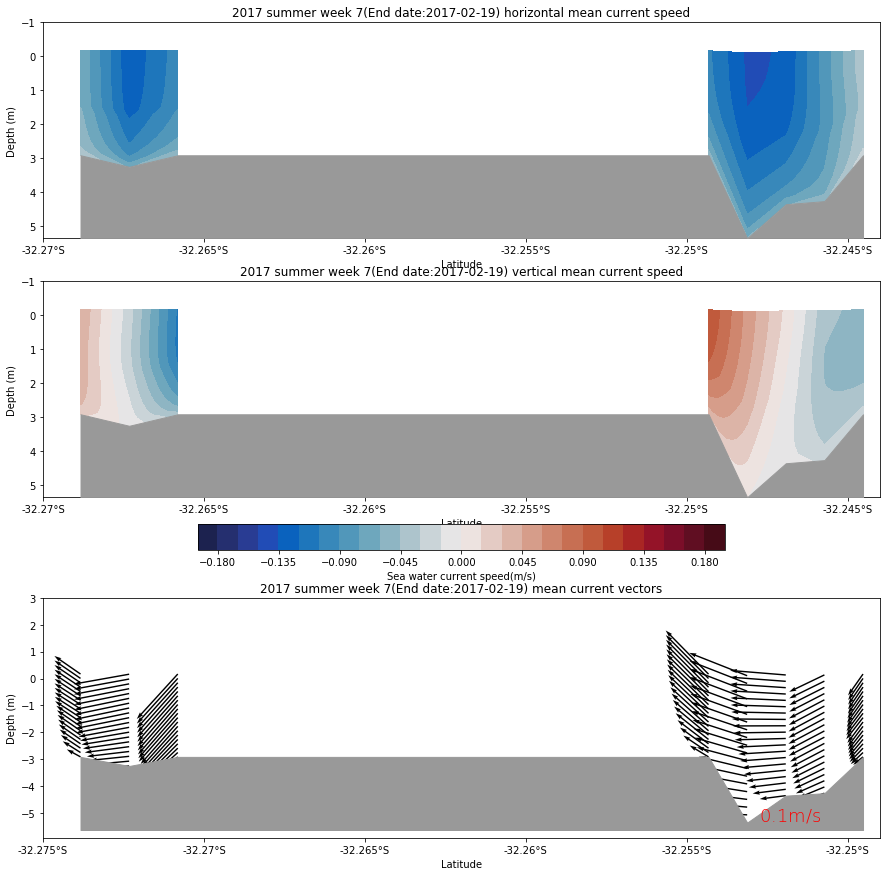

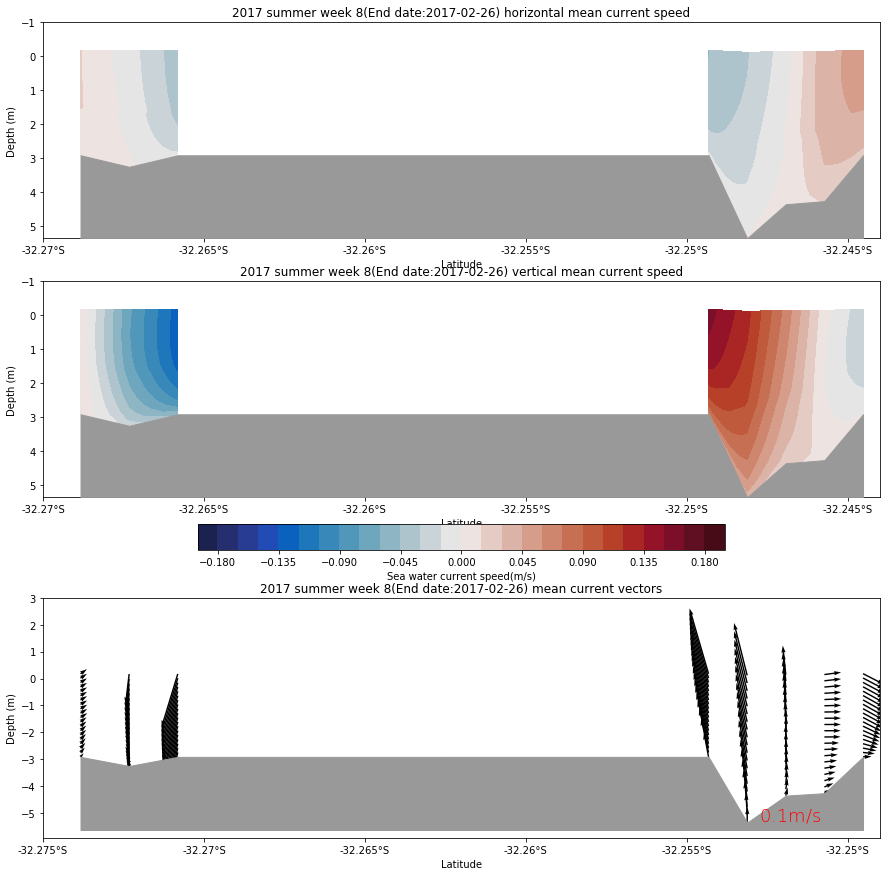

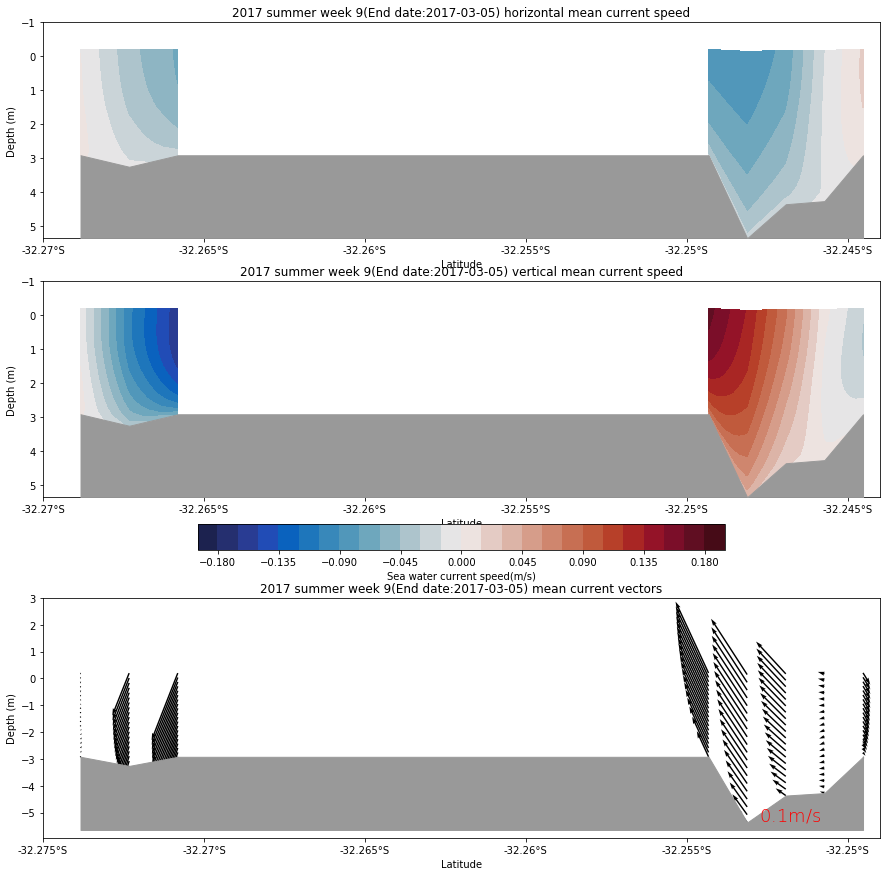

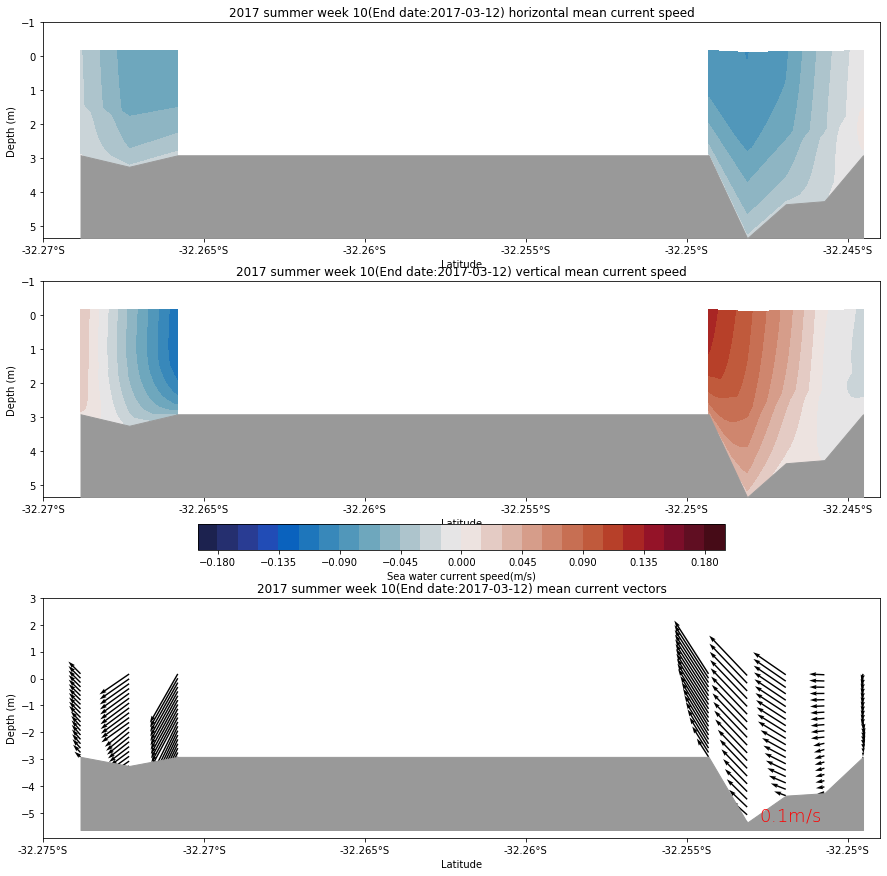

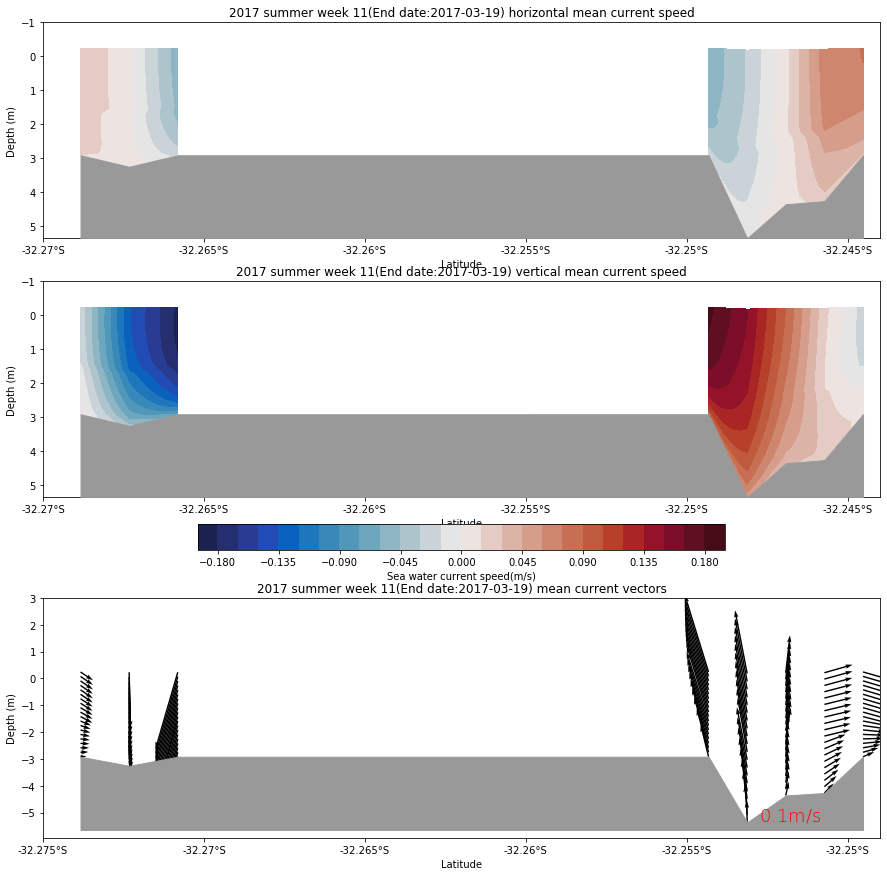

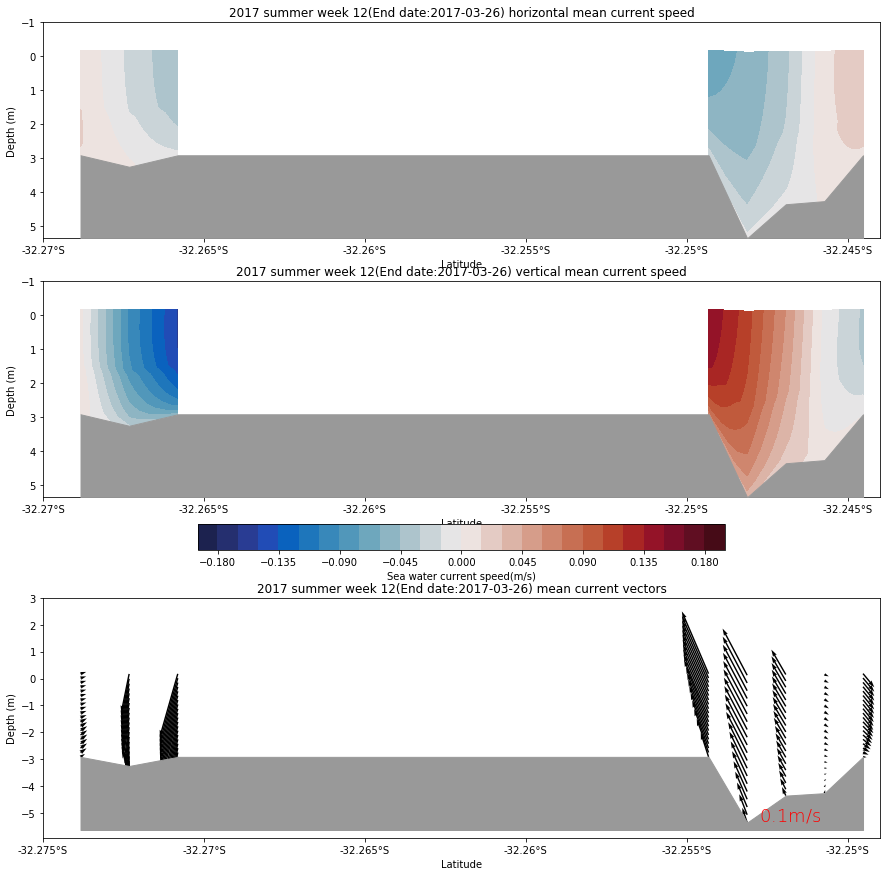

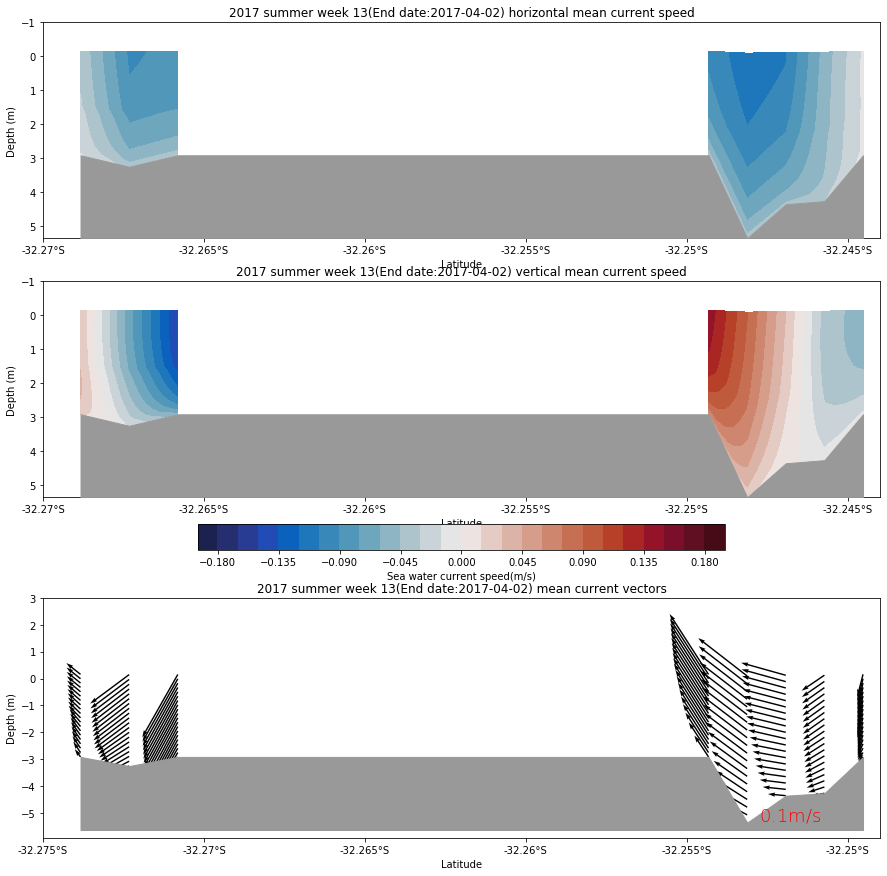

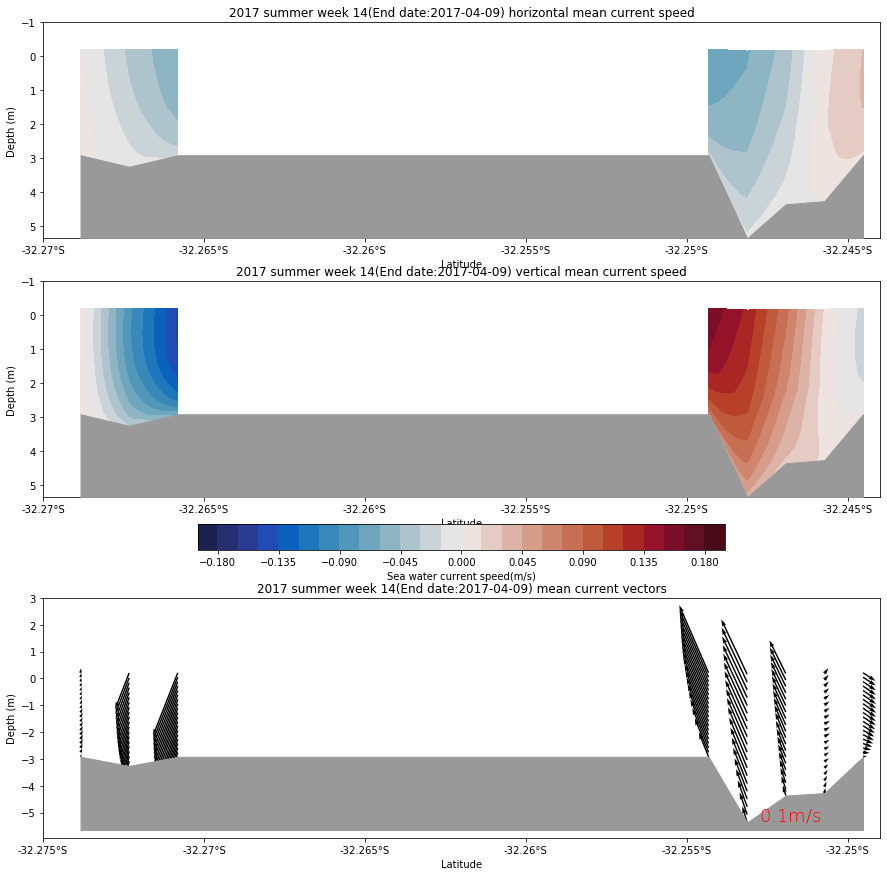

In [135]:
image_list = []
levels = MaxNLocator(nbins=25).tick_values(-np.array([np.abs(zu[31:31+14,...]),np.abs(zv[31:31+14,...])]).max(), np.array([np.abs(zu[31:31+13,...]),np.abs(zv[31:31+13,...])]).max())
for picn, pictime in enumerate(zz.time):
    
    zuu = zu._variable._data[picn,:,:].T
    zvv = zv._variable._data[picn,:,:].T
    if picn>=31 and picn <=31 +13:
        timestr = str(pictime._variable._data)[:10]
        fig, axs = plt.subplots(3,1,figsize=(15, 15))
        ax = axs[0]
        plot = Depth(fvcom,figure = fig, axes = ax, 
                     cb_label='Current speed ({})'.format(fvcom.atts.u.units),
                     cmap=cm.balance)
        depth = -zz[picn,:,:]

        tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zuu[:,:5] ,cmap=cm.balance,levels = levels)
        tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zuu[:,5:] ,cmap=cm.balance,levels = levels)
        contour_adjust(plot)
        plot.axes.set_title('2017 summer week '+str(picn-30)+'(End date:'+ timestr+ ') horizontal mean current speed')

        plot.axes = axs[1]
        tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zvv[:,:5] ,cmap=cm.balance,levels = levels)
        tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zvv[:,5:] ,cmap=cm.balance,levels = levels)
        contour_adjust(plot)
        plot.axes.set_title('2017 summer week '+str(picn-30)+'(End date:'+ timestr+ ') vertical mean current speed')

        # Add a nice colour bar.
        cb = fig.colorbar(tp, ax=axs[0:2],orientation= "horizontal", pad=0.05, fraction=.05,extendrect = False,shrink = 0.7)
        cb.set_label("Sea water current speed(m/s)")


        plot.axes = axs[2]
        plot.plot_quiver(x, depth,
                        zuu,
                        zvv,
                        fill_seabed=True,
                        width=0.0017,scale = 2)
        draw_par(plot)
        plot.axes.set_title('2017 summer week '+str(picn-30)+'(End date:'+ timestr+ ') mean current vectors')
        plt.savefig(picpath+'summer_week/week_'+str(picn-30)+'_uv.png')
        plt.show()

# Season summer

In [136]:
zu = ds.resample(time = '1m').mean()['u']
zv = ds.resample(time = '1m').mean()['v']
zz = ds.resample(time = '1m').mean()['z']

zuu = np.mean(zu._variable._data[6:9,:,:],0).T
zvv = np.mean(zv._variable._data[6:9,:,:],0).T

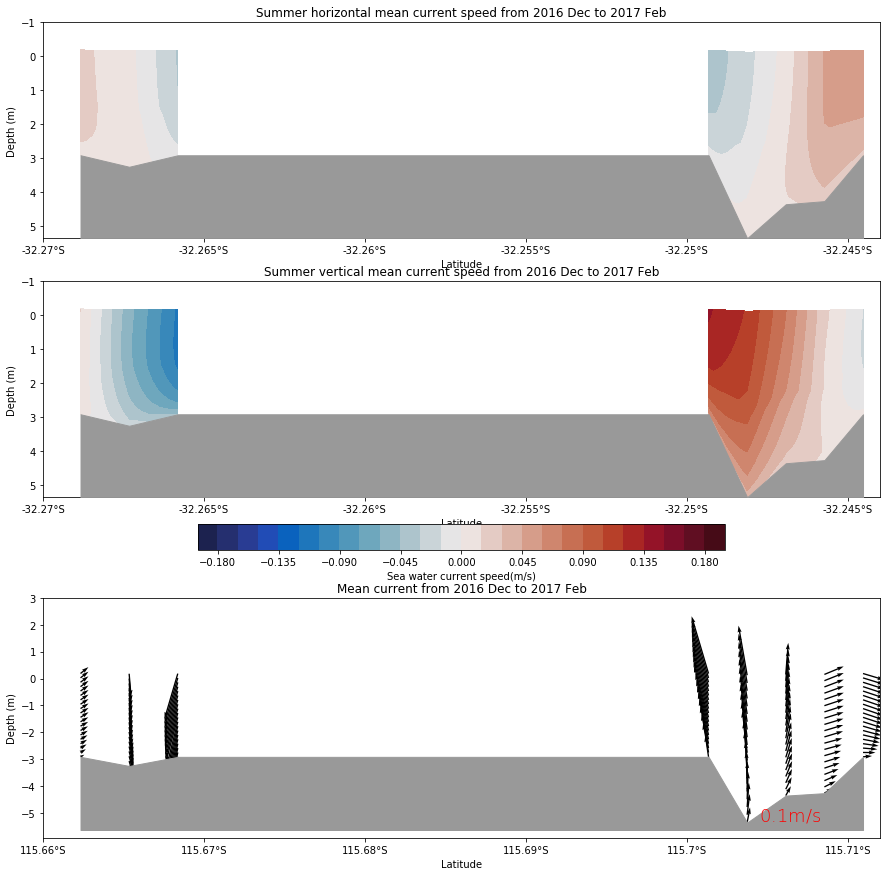

In [137]:
levels = MaxNLocator(nbins=25).tick_values(-np.array([np.abs(zu),np.abs(zv)]).max(), np.array([np.abs(zu),np.abs(zv)]).max())
fig, axs = plt.subplots(3,1,figsize=(15, 15))
ax = axs[0]
plot = Depth(fvcom,figure = fig, axes = ax, 
             cb_label='Current speed ({})'.format(fvcom.atts.u.units),
             cmap=cm.balance)

# fill_seabed makes the part of the plot below the seabed grey.
#x = np.tile(ds.variables['lon'][:],(20,1))
depth = (-np.mean(z,1))._data
tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zuu[:,:5] ,cmap=cm.balance,levels = levels)
tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zuu[:,5:] ,cmap=cm.balance,levels = levels)
contour_adjust(plot)
plot.axes.set_title('Summer horizontal mean current speed from 2016 Dec to 2017 Feb')


plot.axes = axs[1]
tp = plot.axes.contourf(x[:,:5], depth[:,:5] , zvv[:,:5] ,cmap=cm.balance,levels = levels)
tp = plot.axes.contourf(x[:,5:], depth[:,5:] , zvv[:,5:] ,cmap=cm.balance,levels = levels)
contour_adjust(plot)
plot.axes.set_title('Summer vertical mean current speed from 2016 Dec to 2017 Feb')

cb = fig.colorbar(tp, ax=axs[0:2],orientation= "horizontal", pad=0.05, fraction=.05,extendrect = False,shrink = 0.7)
cb.set_label("Sea water current speed(m/s)")

## all average
#z = make_water_column(ds.variables['zeta'][:]._data.T, ds.variables['h'][:]._data, fvcom2.grid.siglay[:,0:31])

plot.axes = axs[2]
plot.plot_quiver(x, depth,
                zuu,
                zvv,
                fill_seabed=True,
                width=0.0016,scale = 2)
plot.axes.set_xlim(115.666,115.74)
plot.axes.set_ylim(top=3)
draw_par(plot)
plot.axes.set_title('Mean current from 2016 Dec to 2017 Feb')
#plt.savefig(picpath+'all_uv_vec.png')

plt.savefig(picpath+'summer_uv.png')
plt.show()